### Unit Validation and Conversion with TimeDB

This notebook demonstrates TimeDB's unit handling capabilities using pint-pandas Series.

#### What you'll learn:
1. **Uploading data with units** - Using pint-pandas Series with `dtype="pint[unit]"` in DataFrames
2. **Reading data and getting unit information** - How to retrieve series metadata including units
3. **Unit validation** - What happens when you try to upload incompatible units to an existing series

**Key Features:**
- Each DataFrame column (except time columns) automatically becomes a separate series
- Series name defaults to the column name
- Units are extracted from pint-pandas Series dtype (e.g., `dtype="pint[MW]"`)
- Values are automatically converted to canonical units before storage
- Incompatible units raise `IncompatibleUnitError`


In [1]:
import timedb as td
import pandas as pd
import pint_pandas
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

# Load environment variables (for database connection)
from dotenv import load_dotenv
load_dotenv()

print("✓ Imports successful")
print(f"✓ Using pint-pandas for unit handling")


✓ Imports successful
✓ Using pint-pandas for unit handling


## Part 1: Uploading Data with Units

Let's start by creating the database schema and then uploading time series data with units embedded as pint-pandas Series.


In [2]:
# Create database schema
td.delete()
td.create()

Creating database schema...
✓ Schema created successfully


In [3]:
# Create sample time series data with units
# We'll create three different series: power (MW), wind speed (m/s), and temperature (°C)

base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
times = [base_time + timedelta(hours=i) for i in range(24)]

# Power values in megawatts (will be stored as canonical unit)
# Round to avoid floating point precision artifacts
power_vals_MW = [round(1.0 + i * 0.05, 2) for i in range(24)]

# Wind speed values in meters per second
wind_vals_m_s = [round(5.0 + i * 0.2, 2) for i in range(24)]

# Temperature values in Celsius
temp_vals_C = [round(20.0 + i * 0.5, 2) for i in range(24)]

# Create DataFrame with pint-pandas Series
# Each column becomes a separate series with its unit specified in the dtype
df = pd.DataFrame({
    "valid_time": times,
    "power": pd.Series(power_vals_MW, dtype="pint[MW]"),              # Series with MW unit
    "wind_speed": pd.Series(wind_vals_m_s, dtype="pint[m/s]"),       # Series with m/s unit
    "temperature": pd.Series(temp_vals_C, dtype="pint[degree_Celsius]")  # Series with °C unit
})

df.head()

,valid_time,power,wind_speed,temperature
0,2025-01-01 00:00:00+00:00,1.0,5.0,20.0
1,2025-01-01 01:00:00+00:00,1.05,5.2,20.5
2,2025-01-01 02:00:00+00:00,1.1,5.4,21.0
3,2025-01-01 03:00:00+00:00,1.15,5.6,21.5
4,2025-01-01 04:00:00+00:00,1.2,5.8,22.0


In [4]:
df.dtypes


valid_time               datetime64[ns, UTC]
power                pint[megawatt][Float64]
wind_speed     pint[meter / second][Float64]
temperature    pint[degree_Celsius][Float64]
dtype: object

In [5]:
# Insert the data - TimeDB automatically:
# 1. Detects each column as a separate series
# 2. Extracts units from pint-pandas Series dtype
# 3. Creates series with name = column name
# 4. Converts values to canonical units and stores them

result = td.insert_batch(df=df)

print("✓ Data inserted successfully!")
print(f"\nBatch ID: {result.batch_id}")
print(f"Workflow ID: {result.workflow_id}")
print(f"Tenant ID: {result.tenant_id}")
print(f"\nSeries created (name -> series_id):")
for name, series_id in result.series_ids.items():
    print(f"  {name}: {series_id}")

# Store the series_ids for later use
series_ids_map = result.series_ids


Data values inserted successfully.
✓ Data inserted successfully!

Batch ID: ef24a6bd-402a-4f63-8d1c-c454401e5c9a
Workflow ID: sdk-workflow
Tenant ID: 00000000-0000-0000-0000-000000000000

Series created (name -> series_id):
  power: a3cb75f7-3328-4026-8960-3c79075e468a
  wind_speed: 46ad278c-d32c-471e-aaf8-d1c3efb3d46e
  temperature: 6feb7937-5c30-4062-b63e-412b569fff2f


## Part 2: Reading Data and Getting Unit Information

Now let's read the data back and see how TimeDB returns unit information along with the values.


In [6]:
# Read all data back
# Columns are the series names (human-readable)
df_read = td.read()

print("✓ Data read successfully")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nColumns: {list(df_read.columns)}")
print(f"\nIndex: {df_read.index.name}")
print(f"\nFirst few rows:")
df_read.head()


✓ Data read successfully

DataFrame shape: (24, 3)

Columns: ['wind_speed', 'temperature', 'power']

Index: valid_time

First few rows:


name,wind_speed,temperature,power
valid_time,,,
2025-01-01 00:00:00+00:00,5.0,20.0,1.0
2025-01-01 01:00:00+00:00,5.2,20.5,1.05
2025-01-01 02:00:00+00:00,5.4,21.0,1.1
2025-01-01 03:00:00+00:00,5.6,21.5,1.15
2025-01-01 04:00:00+00:00,5.8,22.0,1.2


In [7]:
# Check the dtypes - each column has a pint-pandas dtype with the unit
print("Column dtypes (with units):")
for col in df_read.columns:
    print(f"  {col}: {df_read[col].dtype}")


Column dtypes (with units):
  wind_speed: pint[meter / second][Float64]
  temperature: pint[degree_Celsius][Float64]
  power: pint[megawatt][Float64]


In [8]:
# Reset index to see valid_time as a column
df_flat = df_read.reset_index()

print("✓ Reset index to see all columns")
print(f"\nColumns: {list(df_flat.columns)}")
print(f"\nSample data:")
print(df_flat.head(10))

# Extract unit information from column dtypes
print(f"\nSeries and their units:")
for col in df_read.columns:
    dtype_str = str(df_read[col].dtype)
    # Extract unit from pint dtype (e.g., "pint[MW]" -> "MW")
    if dtype_str.startswith("pint["):
        unit = dtype_str[5:-1]  # Remove "pint[" and "]"
        print(f"  {col}: {unit}")


✓ Reset index to see all columns

Columns: ['valid_time', 'wind_speed', 'temperature', 'power']

Sample data:
name                valid_time  wind_speed  temperature  power
0    2025-01-01 00:00:00+00:00         5.0         20.0    1.0
1    2025-01-01 01:00:00+00:00         5.2         20.5   1.05
2    2025-01-01 02:00:00+00:00         5.4         21.0    1.1
3    2025-01-01 03:00:00+00:00         5.6         21.5   1.15
4    2025-01-01 04:00:00+00:00         5.8         22.0    1.2
5    2025-01-01 05:00:00+00:00         6.0         22.5   1.25
6    2025-01-01 06:00:00+00:00         6.2         23.0    1.3
7    2025-01-01 07:00:00+00:00         6.4         23.5   1.35
8    2025-01-01 08:00:00+00:00         6.6         24.0    1.4
9    2025-01-01 09:00:00+00:00         6.8         24.5   1.45

Series and their units:
  wind_speed: meter / second][Float64
  temperature: degree_Celsius][Float64
  power: megawatt][Float64


<Axes: ylabel='meter/second'>

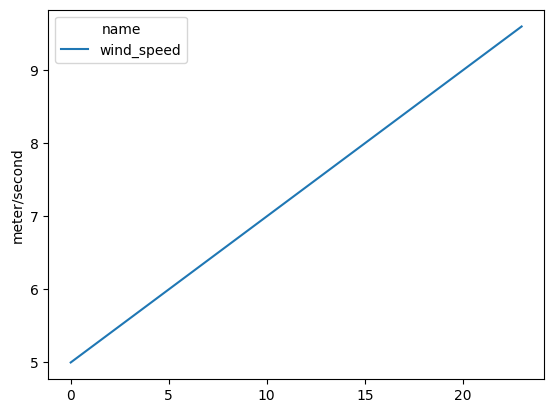

In [9]:
pint_pandas.PintType.ureg.setup_matplotlib()
df_flat[["wind_speed"]].plot()


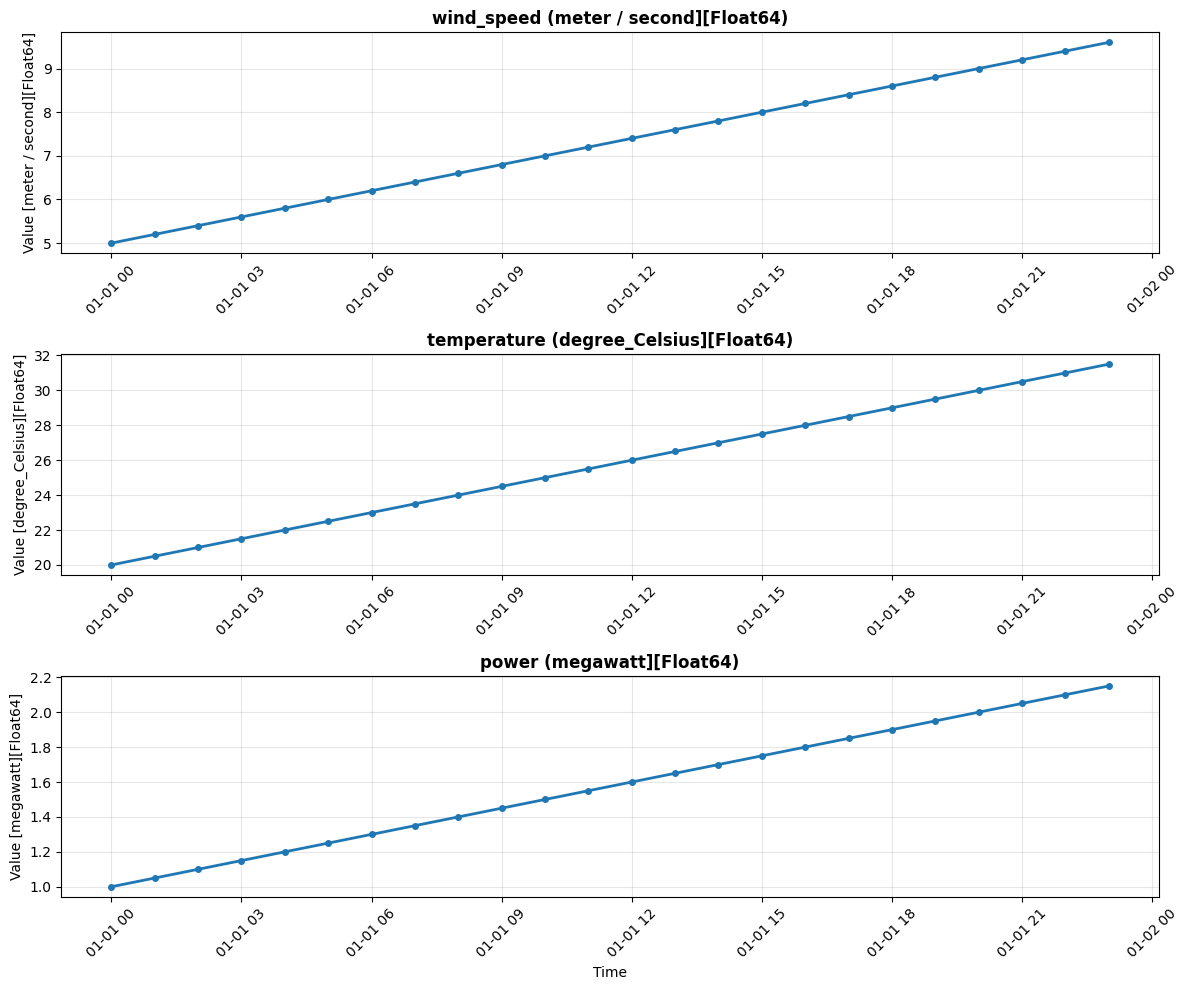

✓ Plotted all series with their units


In [10]:
# Visualize the data with unit information in the plot
# Note: setup_matplotlib() was already called in the previous cell
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Extract units from column dtypes
for idx, series_name in enumerate(df_read.columns):
    # Extract unit from pint dtype
    dtype_str = str(df_read[series_name].dtype)
    if dtype_str.startswith("pint["):
        unit = dtype_str[5:-1]  # Remove "pint[" and "]"
    else:
        unit = "dimensionless"
    
    # Extract numeric values from pint-pandas Series for plotting
    # pint-pandas Series contain Pint Quantity objects, so we need to extract magnitudes
    # Note: For individual series plotting with subplots, we extract magnitudes.
    # pint-pandas matplotlib support works best with DataFrame.plot() for multiple columns
    values = df_read[series_name].apply(lambda x: float(x.magnitude) if hasattr(x, 'magnitude') else float(x))
    
    # Plot the series
    axes[idx].plot(df_read.index, values, marker='o', linewidth=2, markersize=4)
    axes[idx].set_title(f'{series_name} ({unit})', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(f'Value [{unit}]', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

axes[-1].set_xlabel('Time', fontsize=10)
plt.tight_layout()
plt.show()

print("✓ Plotted all series with their units")


## Part 3: Unit Validation - Incompatible Units Error

Now let's try to upload new data to an existing series, but with incompatible units. This should raise an `IncompatibleUnitError`.

**Important:** Once a series is created with a canonical unit (e.g., "kW" for power), all subsequent data must have compatible units (e.g., "MW", "W", "kW" are all compatible as they're all power units). However, trying to use incompatible units (e.g., "MWh" for a power series) will raise an error.


In [11]:
# Get the series_id for the "power" series
power_series_id = result.series_ids['power']
print(f"Power series ID: {power_series_id}")

# Check what unit the power series uses (extract from dtype)
power_dtype = str(df_read['power'].dtype)
if power_dtype.startswith("pint["):
    canonical_unit = power_dtype
else:
    canonical_unit = "dimensionless"

print(f"Power series canonical unit: {canonical_unit}")
print(f"\nThis means all power values are stored in {canonical_unit}")
print(f"Note: The original data was in MW, which is now the canonical unit for this series.")


Power series ID: a3cb75f7-3328-4026-8960-3c79075e468a
Power series canonical unit: pint[megawatt][Float64]

This means all power values are stored in pint[megawatt][Float64]
Note: The original data was in MW, which is now the canonical unit for this series.


In [12]:
# Example 1: Uploading compatible units (kW -> MW conversion)
# This should work fine - kW and MW are compatible (both are power units)

print("Example 1: Uploading compatible units (kW to MW series)")
print("=" * 60)

# Create new data in kilowatts (compatible with MW - will be converted)
new_times = [base_time + timedelta(hours=i) for i in range(24, 48)]
power_vals_kW = [100.0 + i * 5.0 for i in range(24)]  # Values in kW

df_compatible = pd.DataFrame({
    "valid_time": new_times,
    "power": pd.Series(power_vals_kW, dtype="pint[kW]")  # kW is compatible with MW
})

try:
    result_compatible = td.insert_batch(df=df_compatible, series_ids=series_ids_map)
    print("✓ SUCCESS: kW values were automatically converted to MW and stored")
    print(f"  Inserted {len(new_times)} new data points")
    print(f"  Note: 100 kW = 0.1 MW (automatic conversion)")
except Exception as e:
    print(f"✗ ERROR: {type(e).__name__}: {e}")


Example 1: Uploading compatible units (kW to MW series)
Data values inserted successfully.
✓ SUCCESS: kW values were automatically converted to MW and stored
  Inserted 24 new data points
  Note: 100 kW = 0.1 MW (automatic conversion)


In [13]:
# Example 2: Uploading incompatible units (MWh -> MW series)
# This should FAIL - MWh (energy) is incompatible with MW (power)

print("\nExample 2: Uploading incompatible units (MWh to MW series)")
print("=" * 60)

# Create new data in megawatt-hours (INCOMPATIBLE with MW - energy vs power!)
new_times2 = [base_time + timedelta(hours=i) for i in range(48, 72)]
energy_vals_MWh = [10.0 + i * 0.5 for i in range(24)]  # Values in MWh

df_incompatible = pd.DataFrame({
    "valid_time": new_times2,
    "power": pd.Series(energy_vals_MWh, dtype="pint[MWh]")  # MWh is INCOMPATIBLE with MW!
})

try:
    result_incompatible = td.insert_batch(df=df_incompatible, series_ids=series_ids_map)
    print("✗ UNEXPECTED: This should have failed but didn't!")
except td.IncompatibleUnitError as e:
    print(f"✓ EXPECTED ERROR: {type(e).__name__}")
    print(f"  Message: {e}")
    print(f"\n  This error occurred because:")
    print(f"    - The 'power' series has canonical unit: {canonical_unit} (power)")
    print(f"    - You tried to upload values with unit: MWh (energy)")
    print(f"    - Power and energy have incompatible dimensionality")
except Exception as e:
    print(f"✗ UNEXPECTED ERROR: {type(e).__name__}: {e}")



Example 2: Uploading incompatible units (MWh to MW series)
✓ EXPECTED ERROR: IncompatibleUnitError
  Message: Cannot convert megawatt_hour to megawatt: incompatible dimensionality (Cannot convert from 'megawatt_hour' ([mass] * [length] ** 2 / [time] ** 2) to 'megawatt' ([mass] * [length] ** 2 / [time] ** 3))

  This error occurred because:
    - The 'power' series has canonical unit: pint[megawatt][Float64] (power)
    - You tried to upload values with unit: MWh (energy)
    - Power and energy have incompatible dimensionality


In [14]:
# Example 3: Uploading compatible but different units (W -> MW series)
# This should work fine - W (watts) is compatible with MW (megawatts)

print("\nExample 3: Uploading compatible but different units (W to MW series)")
print("=" * 60)

# Create new data in watts (compatible with MW - just a different scale)
new_times3 = [base_time + timedelta(hours=i) for i in range(72, 96)]
power_vals_W = [100000.0 + i * 5000.0 for i in range(24)]  # Values in W

df_watts = pd.DataFrame({
    "valid_time": new_times3,
    "power": pd.Series(power_vals_W, dtype="pint[W]")  # W is compatible with MW
})

try:
    result_watts = td.insert_batch(df=df_watts, series_ids=series_ids_map)
    print("✓ SUCCESS: W values were automatically converted to MW and stored")
    print(f"  Inserted {len(new_times3)} new data points")
    print(f"  Note: 100000 W = 0.1 MW (automatic conversion)")
except Exception as e:
    print(f"✗ ERROR: {type(e).__name__}: {e}")



Example 3: Uploading compatible but different units (W to MW series)
Data values inserted successfully.
✓ SUCCESS: W values were automatically converted to MW and stored
  Inserted 24 new data points
  Note: 100000 W = 0.1 MW (automatic conversion)


## Summary

This notebook demonstrated:

1. **Uploading data with units**: Using pint-pandas Series with `dtype="pint[unit]"` in DataFrame columns automatically creates series with units extracted from the dtype.

2. **Reading data with unit information**: The `read()` function returns a pivoted DataFrame with `series_key` as column names and pint-pandas dtypes (e.g., `dtype="pint[MW]"`) so you always know what unit the stored values are in.

3. **Unit validation**: TimeDB prevents storing incompatible units in the same series:
   - ✅ Compatible units (kW, MW, W) → Automatic conversion
   - ❌ Incompatible units (MW vs MWh) → `IncompatibleUnitError`

**Key Takeaways:**
- Each DataFrame column becomes a separate series
- Series name defaults to column name
- Units are extracted from pint-pandas Series dtype (e.g., `dtype="pint[MW]"`)
- Values are converted to canonical units before storage
- Incompatible units are rejected with clear error messages
- The `read()` function returns a DataFrame with series names as columns and units in the dtype


In [15]:
# Final verification: Read all data to see the complete time series
df_final = td.read()

print("✓ Final data read")
print(f"\nTotal rows: {len(df_final)}")
print(f"\nSeries in database:")
for series_name in df_final.columns:
    # Extract unit from dtype
    dtype_str = str(df_final[series_name].dtype)
    if dtype_str.startswith("pint["):
        unit = dtype_str[5:-1]  # Extract unit from "pint[MW]"
    else:
        unit = "dimensionless"
    count = len(df_final[df_final[series_name].notna()])
    print(f"  {series_name} ({unit}): {count} data points")


✓ Final data read

Total rows: 72

Series in database:
  wind_speed (meter / second][Float64): 24 data points
  temperature (degree_Celsius][Float64): 24 data points
  power (megawatt][Float64): 72 data points
